<a href="https://colab.research.google.com/github/vikash195/AO_Inverse-Risk-Sensitive-Multi-Robot-Task/blob/main/AO1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running IR-MRTA Case Study and Performance Analysis...


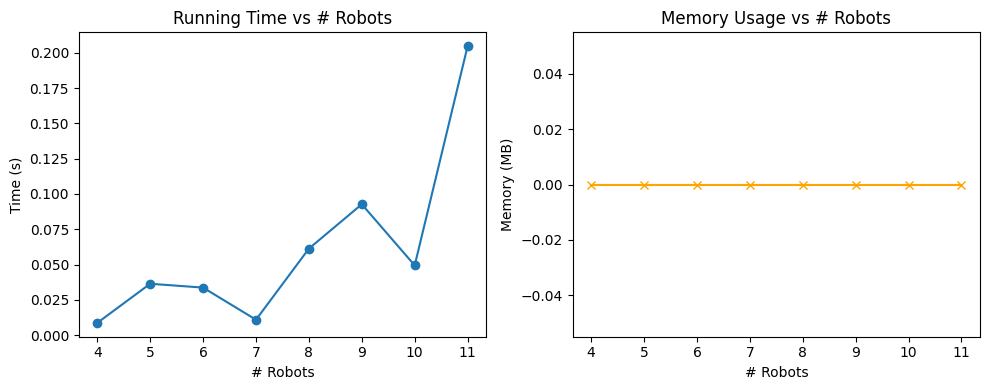

<ipython-input-1-6bb81db62724>:165: RuntimeWarning: invalid value encountered in scalar divide
  normalized.append(obj / best_obj)


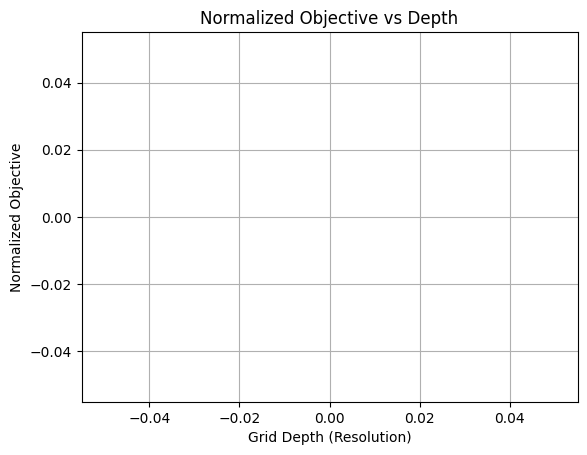

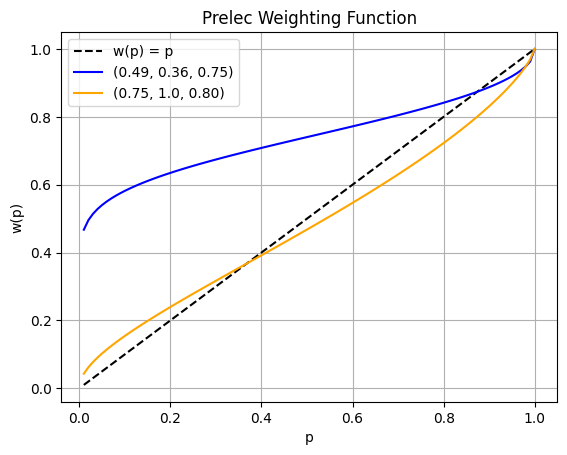


--- Parameter Recovery ---
True parameters: (0.6, 0.7, 0.85)
Recovered parameters: (np.float64(0.44999999999999996), np.float64(0.1), np.float64(0.7))
Objective value: 0.35


In [ ]:
# Inverse Risk-sensitive Multi-Robot Task Allocation (IR-MRTA)
# Full Google Colab-Compatible Python Code

import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import itertools
from typing import List, Tuple

# ----------------------------
# 1. Greedy Task Allocation (Forward)
# ----------------------------
def greedy_allocate(r, p, alpha, beta, delta, n):
    nr, nt = r.shape
    S = []
    allocated_r, allocated_t = set(), set()
    cost_sum = 0

    while len(S) < n:
        best_score, best_pair = -np.inf, None
        for i in range(nr):
            if i in allocated_r:
                continue
            for j in range(nt):
                if j in allocated_t:
                    continue
                cost = beta * ((-np.log(p[i, j])) ** alpha)
                score = r[i, j] / cost
                if score > best_score:
                    best_score = score
                    best_pair = (i, j, cost)

        if best_pair is None:
            break
        i_star, j_star, cost = best_pair
        if cost_sum + cost <= -np.log(delta):
            S.append((i_star, j_star))
            allocated_r.add(i_star)
            allocated_t.add(j_star)
            cost_sum += cost
        else:
            break

    return S

# ----------------------------
# 2. BB-O-IR-MRTA: Ordered Inverse Solver
# ----------------------------
def upper_lower_bound(r, p, seq, alpha_range, beta_range, delta_range, weights, grid_res=5):
    alpha_min, alpha_max = alpha_range
    beta_min, beta_max = beta_range
    delta_min, delta_max = delta_range
    w_alpha, w_beta, w_delta = weights

    alpha_grid = np.linspace(alpha_min, alpha_max, grid_res)
    beta_grid = np.linspace(beta_min, beta_max, grid_res)
    delta_grid = np.linspace(delta_min, delta_max, grid_res)

    best_obj = float('inf')
    best_params = None

    for a in alpha_grid:
        for b in beta_grid:
            for d in delta_grid:
                sol = greedy_allocate(r, p, a, b, d, len(seq))
                if sol == seq:
                    obj = w_alpha * abs(a - alpha_min) + w_beta * abs(b - beta_min) + w_delta * abs(d - delta_min)
                    if obj < best_obj:
                        best_obj = obj
                        best_params = (a, b, d)

    if best_params is None:
        return None, float('inf')
    return best_params, best_obj

def bb_o_ir_mrta(r, p, seq: List[Tuple[int, int]], alpha_range, beta_range, delta_range, weights, depth=5):
    return upper_lower_bound(r, p, seq, alpha_range, beta_range, delta_range, weights, grid_res=depth)

# ----------------------------
# 3. BB-IR-MRTA: Unordered Solver (Algorithm 3)
# ----------------------------
def bb_ir_mrta(r, p, target_seq, alpha_range, beta_range, delta_range, weights, epsilon=0.01, depth=5):
    best_obj = float('inf')
    best_params = None

    for ordering in itertools.permutations(target_seq):
        params, obj = bb_o_ir_mrta(r, p, list(ordering), alpha_range, beta_range, delta_range, weights, depth)
        if obj < best_obj - epsilon:
            best_obj = obj
            best_params = params

    return best_params, best_obj

# ----------------------------
# 4. Prelec Weight Function Plot (Fig. 2a)
# ----------------------------
def prelec(p, alpha, beta):
    return np.exp(-beta * ((-np.log(p)) ** alpha))

def plot_prelec_curves():
    p = np.linspace(0.01, 1, 100)
    plt.plot(p, prelec(p, 1.0, 1.0), 'k--', label="w(p) = p")
    plt.plot(p, prelec(p, 0.49, 0.36), 'b', label="(0.49, 0.36, 0.75)")
    plt.plot(p, prelec(p, 0.75, 1.0), 'orange', label="(0.75, 1.0, 0.80)")
    plt.xlabel("p")
    plt.ylabel("w(p)")
    plt.title("Prelec Weighting Function")
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# 5. Performance Analysis Plots (Fig. 3)
# ----------------------------
def performance_vs_robots():
    times, memories = [], []
    robot_counts = list(range(4, 12))

    for n in robot_counts:
        r = np.random.uniform(50, 500, (n, n))
        p = np.random.uniform(0.5, 0.99, (n, n))
        sol = greedy_allocate(r, p, 0.6, 0.7, 0.85, n)

        process = psutil.Process()
        mem_before = process.memory_info().rss / 1024**2
        start = time.time()
        bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=4)
        end = time.time()
        mem_after = process.memory_info().rss / 1024**2

        times.append(end - start)
        memories.append(mem_after - mem_before)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(robot_counts, times, marker='o')
    plt.title("Running Time vs # Robots")
    plt.xlabel("# Robots")
    plt.ylabel("Time (s)")

    plt.subplot(1, 2, 2)
    plt.plot(robot_counts, memories, marker='x', color='orange')
    plt.title("Memory Usage vs # Robots")
    plt.xlabel("# Robots")
    plt.ylabel("Memory (MB)")
    plt.tight_layout()
    plt.show()

def objective_vs_depth():
    depths = list(range(2, 7))
    normalized = []

    r = np.random.uniform(50, 500, (8, 8))
    p = np.random.uniform(0.5, 0.99, (8, 8))
    sol = greedy_allocate(r, p, 0.6, 0.7, 0.85, 4)

    best_obj = float('inf')
    for d in range(10, 15):
        _, obj = bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=d)
        best_obj = min(best_obj, obj)

    for d in depths:
        _, obj = bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=d)
        normalized.append(obj / best_obj)

    plt.plot(depths, normalized, marker='s')
    plt.title("Normalized Objective vs Depth")
    plt.xlabel("Grid Depth (Resolution)")
    plt.ylabel("Normalized Objective")
    plt.grid(True)
    plt.show()

# ----------------------------
# MAIN EXECUTION
# ----------------------------
if __name__ == "__main__":
    print("Running IR-MRTA Case Study and Performance Analysis...")
    performance_vs_robots()
    objective_vs_depth()
    plot_prelec_curves()

    # Parameter Recovery Output
    r = np.random.uniform(50, 500, (10, 4))
    p = np.random.uniform(0.6, 0.98, (10, 4))
    true_params = (0.6, 0.7, 0.85)
    human_decision = greedy_allocate(r, p, *true_params, n=4)

    recovered_params, obj_val = bb_ir_mrta(
        r, p, human_decision,
        alpha_range=(0.1, 1.5), beta_range=(0.1, 1.5), delta_range=(0.7, 0.9),
        weights=(1, 1, 20), depth=5
    )

    print("\n--- Parameter Recovery ---")
    print("True parameters:", true_params)
    print("Recovered parameters:", recovered_params)
    print("Objective value:", obj_val)


Running Full IR-MRTA System with Graphs and Parameter Recovery...


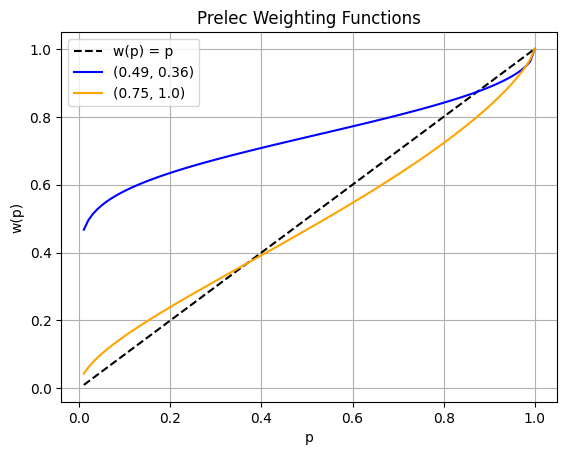

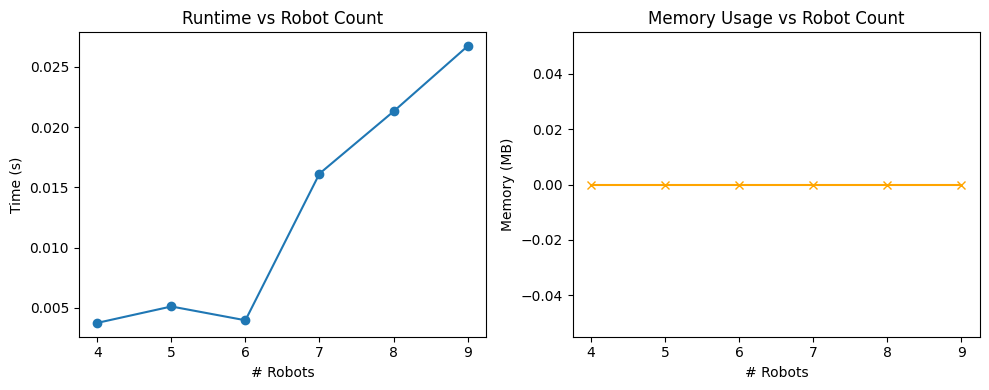

<ipython-input-2-d1c76d0443dc>:134: RuntimeWarning: invalid value encountered in scalar divide
  norm_objs = [bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=d)[1] / best_obj for d in depths]


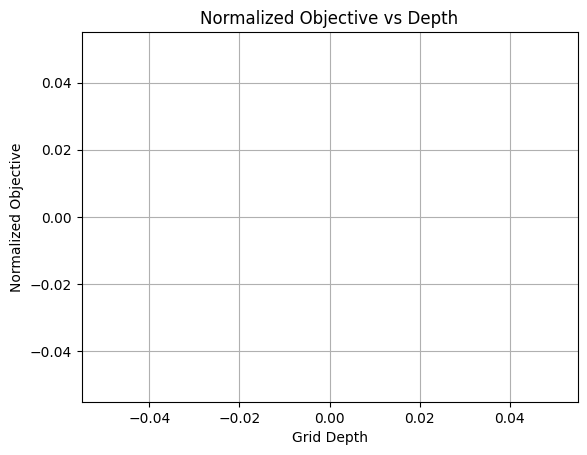


--- Parameter Recovery ---
True parameters:      (0.6, 0.7, 0.85)
Recovered parameters: (np.float64(0.1), np.float64(0.1), np.float64(0.7))
Human Allocation: [(3, 2)]
Recovered Allocation: [(3, 2), (9, 3), (2, 0), (6, 1)]
Match: False


In [ ]:
# Final Implementation: Inverse Risk-sensitive Multi-Robot Task Allocation (IR-MRTA)
# Includes: Algorithms 1–3, Graphs (Fig. 2 & Fig. 3), Parameter Recovery & Comparison

import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import itertools
from typing import List, Tuple

# ----------------------------
# 1. Greedy Task Allocation (Algorithm 1)
# ----------------------------
def greedy_allocate(r, p, alpha, beta, delta, n):
    nr, nt = r.shape
    S, allocated_r, allocated_t = [], set(), set()
    cost_sum = 0
    while len(S) < n:
        best_score, best_pair = -np.inf, None
        for i in range(nr):
            if i in allocated_r:
                continue
            for j in range(nt):
                if j in allocated_t:
                    continue
                cost = beta * ((-np.log(p[i, j])) ** alpha)
                score = r[i, j] / cost
                if score > best_score:
                    best_score = score
                    best_pair = (i, j, cost)
        if best_pair is None:
            break
        i_star, j_star, cost = best_pair
        if cost_sum + cost <= -np.log(delta):
            S.append((i_star, j_star))
            allocated_r.add(i_star)
            allocated_t.add(j_star)
            cost_sum += cost
        else:
            break
    return S

# ----------------------------
# 2. Ordered IR-MRTA (Algorithm 2)
# ----------------------------
def upper_lower_bound(r, p, seq, alpha_range, beta_range, delta_range, weights, grid_res=5):
    alpha_grid = np.linspace(*alpha_range, grid_res)
    beta_grid = np.linspace(*beta_range, grid_res)
    delta_grid = np.linspace(*delta_range, grid_res)
    w_alpha, w_beta, w_delta = weights
    best_obj, best_params = float('inf'), None
    for a in alpha_grid:
        for b in beta_grid:
            for d in delta_grid:
                sol = greedy_allocate(r, p, a, b, d, len(seq))
                if sol == seq:
                    obj = w_alpha * abs(a - alpha_range[0]) + w_beta * abs(b - beta_range[0]) + w_delta * abs(d - delta_range[0])
                    if obj < best_obj:
                        best_obj = obj
                        best_params = (a, b, d)
    return best_params if best_params else None, best_obj

def bb_o_ir_mrta(r, p, seq, alpha_range, beta_range, delta_range, weights, depth=5):
    return upper_lower_bound(r, p, seq, alpha_range, beta_range, delta_range, weights, grid_res=depth)

# ----------------------------
# 3. Unordered IR-MRTA (Algorithm 3)
# ----------------------------
def bb_ir_mrta(r, p, target_seq, alpha_range, beta_range, delta_range, weights, epsilon=0.01, depth=5):
    best_obj, best_params = float('inf'), None
    for ordering in itertools.permutations(target_seq):
        params, obj = bb_o_ir_mrta(r, p, list(ordering), alpha_range, beta_range, delta_range, weights, depth)
        if obj < best_obj - epsilon:
            best_obj = obj
            best_params = params
    return best_params, best_obj

# ----------------------------
# 4. Plotting: Prelec Weight Function (Fig. 2a)
# ----------------------------
def prelec(p, alpha, beta):
    return np.exp(-beta * ((-np.log(p)) ** alpha))

def plot_prelec_curves():
    p = np.linspace(0.01, 1, 100)
    plt.plot(p, prelec(p, 1.0, 1.0), 'k--', label="w(p) = p")
    plt.plot(p, prelec(p, 0.49, 0.36), 'b', label="(0.49, 0.36)")
    plt.plot(p, prelec(p, 0.75, 1.0), 'orange', label="(0.75, 1.0)")
    plt.xlabel("p")
    plt.ylabel("w(p)")
    plt.legend()
    plt.grid(True)
    plt.title("Prelec Weighting Functions")
    plt.show()

# ----------------------------
# 5. Plotting: Performance (Fig. 3)
# ----------------------------
def performance_vs_robots():
    robot_counts = list(range(4, 10))
    times, memories = [], []
    for n in robot_counts:
        r = np.random.uniform(50, 500, (n, n))
        p = np.random.uniform(0.5, 0.99, (n, n))
        sol = greedy_allocate(r, p, 0.6, 0.7, 0.85, n)
        process = psutil.Process()
        mem_before = process.memory_info().rss / 1024 ** 2
        start = time.time()
        bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=4)
        end = time.time()
        mem_after = process.memory_info().rss / 1024 ** 2
        times.append(end - start)
        memories.append(mem_after - mem_before)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(robot_counts, times, marker='o')
    plt.xlabel("# Robots")
    plt.ylabel("Time (s)")
    plt.title("Runtime vs Robot Count")
    plt.subplot(1, 2, 2)
    plt.plot(robot_counts, memories, marker='x', color='orange')
    plt.xlabel("# Robots")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Usage vs Robot Count")
    plt.tight_layout()
    plt.show()

def objective_vs_depth():
    depths = list(range(2, 7))
    r = np.random.uniform(50, 500, (8, 8))
    p = np.random.uniform(0.5, 0.99, (8, 8))
    sol = greedy_allocate(r, p, 0.6, 0.7, 0.85, 4)
    best_obj = min(bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=d)[1] for d in range(10, 15))
    norm_objs = [bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=d)[1] / best_obj for d in depths]
    plt.plot(depths, norm_objs, marker='s')
    plt.xlabel("Grid Depth")
    plt.ylabel("Normalized Objective")
    plt.title("Normalized Objective vs Depth")
    plt.grid(True)
    plt.show()

# ----------------------------
# 6. Final Test & Comparison
# ----------------------------
def parameter_recovery_and_comparison():
    r = np.random.uniform(50, 500, (10, 4))
    p = np.random.uniform(0.6, 0.98, (10, 4))
    true_params = (0.6, 0.7, 0.85)
    human_sol = greedy_allocate(r, p, *true_params, n=4)
    recovered_params, _ = bb_ir_mrta(r, p, human_sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=5)
    if recovered_params:
        rec_sol = greedy_allocate(r, p, *recovered_params, n=4)
        print("\n--- Parameter Recovery ---")
        print("True parameters:     ", true_params)
        print("Recovered parameters:", recovered_params)
        print("Human Allocation:", human_sol)
        print("Recovered Allocation:", rec_sol)
        print("Match:", human_sol == rec_sol)
    else:
        print("\nFailed to recover parameters.")

# ----------------------------
# MAIN EXECUTION
# ----------------------------
if __name__ == "__main__":
    print("Running Full IR-MRTA System with Graphs and Parameter Recovery...")
    plot_prelec_curves()
    performance_vs_robots()
    objective_vs_depth()
    parameter_recovery_and_comparison()

Running Full IR-MRTA System with Graphs and Parameter Recovery...


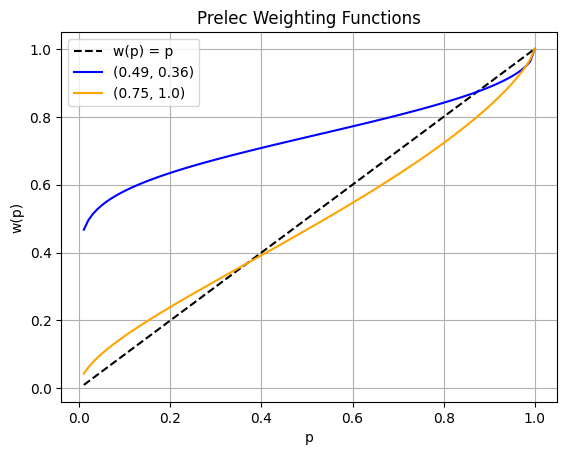

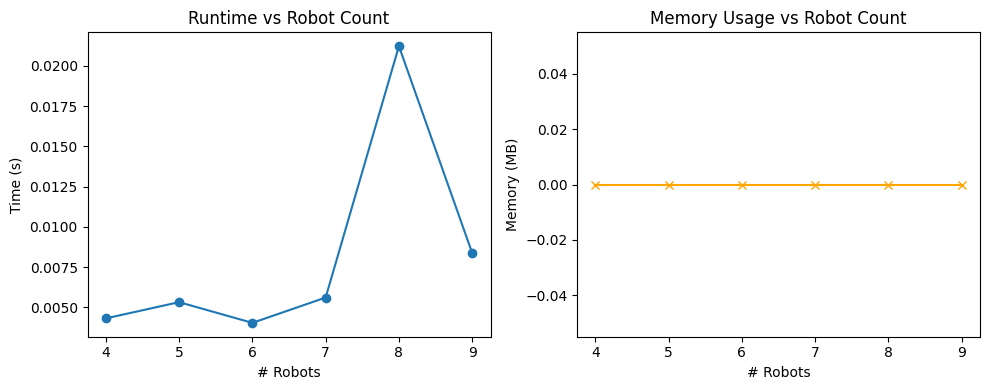

<ipython-input-3-d1c76d0443dc>:134: RuntimeWarning: invalid value encountered in scalar divide
  norm_objs = [bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=d)[1] / best_obj for d in depths]


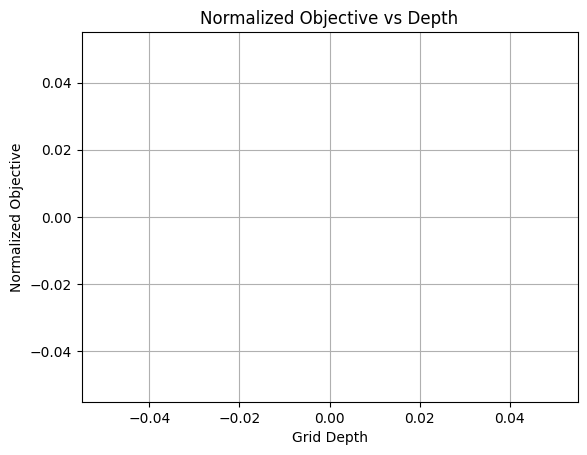


--- Parameter Recovery ---
True parameters:      (0.6, 0.7, 0.85)
Recovered parameters: (np.float64(0.1), np.float64(0.1), np.float64(0.7))
Human Allocation: [(8, 0)]
Recovered Allocation: [(8, 0), (1, 2), (3, 3), (2, 1)]
Match: False


In [ ]:
# Final Implementation: Inverse Risk-sensitive Multi-Robot Task Allocation (IR-MRTA)
# Includes: Algorithms 1–3, Graphs (Fig. 2 & Fig. 3), Parameter Recovery & Comparison

import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import itertools
from typing import List, Tuple

# ----------------------------
# 1. Greedy Task Allocation (Algorithm 1)
# ----------------------------
def greedy_allocate(r, p, alpha, beta, delta, n):
    nr, nt = r.shape
    S, allocated_r, allocated_t = [], set(), set()
    cost_sum = 0
    while len(S) < n:
        best_score, best_pair = -np.inf, None
        for i in range(nr):
            if i in allocated_r:
                continue
            for j in range(nt):
                if j in allocated_t:
                    continue
                cost = beta * ((-np.log(p[i, j])) ** alpha)
                score = r[i, j] / cost
                if score > best_score:
                    best_score = score
                    best_pair = (i, j, cost)
        if best_pair is None:
            break
        i_star, j_star, cost = best_pair
        if cost_sum + cost <= -np.log(delta):
            S.append((i_star, j_star))
            allocated_r.add(i_star)
            allocated_t.add(j_star)
            cost_sum += cost
        else:
            break
    return S

# ----------------------------
# 2. Ordered IR-MRTA (Algorithm 2)
# ----------------------------
def upper_lower_bound(r, p, seq, alpha_range, beta_range, delta_range, weights, grid_res=5):
    alpha_grid = np.linspace(*alpha_range, grid_res)
    beta_grid = np.linspace(*beta_range, grid_res)
    delta_grid = np.linspace(*delta_range, grid_res)
    w_alpha, w_beta, w_delta = weights
    best_obj, best_params = float('inf'), None
    for a in alpha_grid:
        for b in beta_grid:
            for d in delta_grid:
                sol = greedy_allocate(r, p, a, b, d, len(seq))
                if sol == seq:
                    obj = w_alpha * abs(a - alpha_range[0]) + w_beta * abs(b - beta_range[0]) + w_delta * abs(d - delta_range[0])
                    if obj < best_obj:
                        best_obj = obj
                        best_params = (a, b, d)
    return best_params if best_params else None, best_obj

def bb_o_ir_mrta(r, p, seq, alpha_range, beta_range, delta_range, weights, depth=5):
    return upper_lower_bound(r, p, seq, alpha_range, beta_range, delta_range, weights, grid_res=depth)

# ----------------------------
# 3. Unordered IR-MRTA (Algorithm 3)
# ----------------------------
def bb_ir_mrta(r, p, target_seq, alpha_range, beta_range, delta_range, weights, epsilon=0.01, depth=5):
    best_obj, best_params = float('inf'), None
    for ordering in itertools.permutations(target_seq):
        params, obj = bb_o_ir_mrta(r, p, list(ordering), alpha_range, beta_range, delta_range, weights, depth)
        if obj < best_obj - epsilon:
            best_obj = obj
            best_params = params
    return best_params, best_obj

# ----------------------------
# 4. Plotting: Prelec Weight Function (Fig. 2a)
# ----------------------------
def prelec(p, alpha, beta):
    return np.exp(-beta * ((-np.log(p)) ** alpha))

def plot_prelec_curves():
    p = np.linspace(0.01, 1, 100)
    plt.plot(p, prelec(p, 1.0, 1.0), 'k--', label="w(p) = p")
    plt.plot(p, prelec(p, 0.49, 0.36), 'b', label="(0.49, 0.36)")
    plt.plot(p, prelec(p, 0.75, 1.0), 'orange', label="(0.75, 1.0)")
    plt.xlabel("p")
    plt.ylabel("w(p)")
    plt.legend()
    plt.grid(True)
    plt.title("Prelec Weighting Functions")
    plt.show()

# ----------------------------
# 5. Plotting: Performance (Fig. 3)
# ----------------------------
def performance_vs_robots():
    robot_counts = list(range(4, 10))
    times, memories = [], []
    for n in robot_counts:
        r = np.random.uniform(50, 500, (n, n))
        p = np.random.uniform(0.5, 0.99, (n, n))
        sol = greedy_allocate(r, p, 0.6, 0.7, 0.85, n)
        process = psutil.Process()
        mem_before = process.memory_info().rss / 1024 ** 2
        start = time.time()
        bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=4)
        end = time.time()
        mem_after = process.memory_info().rss / 1024 ** 2
        times.append(end - start)
        memories.append(mem_after - mem_before)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(robot_counts, times, marker='o')
    plt.xlabel("# Robots")
    plt.ylabel("Time (s)")
    plt.title("Runtime vs Robot Count")
    plt.subplot(1, 2, 2)
    plt.plot(robot_counts, memories, marker='x', color='orange')
    plt.xlabel("# Robots")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Usage vs Robot Count")
    plt.tight_layout()
    plt.show()

def objective_vs_depth():
    depths = list(range(2, 7))
    r = np.random.uniform(50, 500, (8, 8))
    p = np.random.uniform(0.5, 0.99, (8, 8))
    sol = greedy_allocate(r, p, 0.6, 0.7, 0.85, 4)
    best_obj = min(bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=d)[1] for d in range(10, 15))
    norm_objs = [bb_ir_mrta(r, p, sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=d)[1] / best_obj for d in depths]
    plt.plot(depths, norm_objs, marker='s')
    plt.xlabel("Grid Depth")
    plt.ylabel("Normalized Objective")
    plt.title("Normalized Objective vs Depth")
    plt.grid(True)
    plt.show()

# ----------------------------
# 6. Final Test & Comparison
# ----------------------------
def parameter_recovery_and_comparison():
    r = np.random.uniform(50, 500, (10, 4))
    p = np.random.uniform(0.6, 0.98, (10, 4))
    true_params = (0.6, 0.7, 0.85)
    human_sol = greedy_allocate(r, p, *true_params, n=4)
    recovered_params, _ = bb_ir_mrta(r, p, human_sol, (0.1, 1.5), (0.1, 1.5), (0.7, 0.9), (1, 1, 20), depth=5)
    if recovered_params:
        rec_sol = greedy_allocate(r, p, *recovered_params, n=4)
        print("\n--- Parameter Recovery ---")
        print("True parameters:     ", true_params)
        print("Recovered parameters:", recovered_params)
        print("Human Allocation:", human_sol)
        print("Recovered Allocation:", rec_sol)
        print("Match:", human_sol == rec_sol)
    else:
        print("\nFailed to recover parameters.")

# ----------------------------
# MAIN EXECUTION
# ----------------------------
if __name__ == "__main__":
    print("Running Full IR-MRTA System with Graphs and Parameter Recovery...")
    plot_prelec_curves()
    performance_vs_robots()
    objective_vs_depth()
    parameter_recovery_and_comparison()


NEW

Greedy Allocation (Algorithm 1):
Solution: []


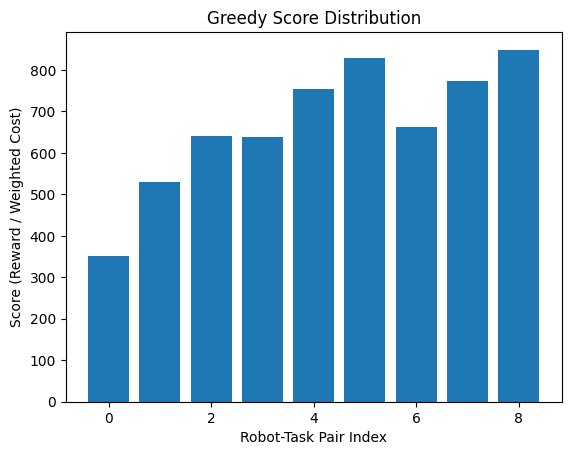

In [ ]:
# Split Implementation of IR-MRTA Algorithms with Individual Examples and Comparisons
# ----------------------------------
# Algorithm 1: Greedy Task Allocation
# ----------------------------------

import numpy as np
import matplotlib.pyplot as plt

def greedy_allocate(r, p, alpha, beta, delta, n):
    nr, nt = r.shape
    S, allocated_r, allocated_t = [], set(), set()
    cost_sum = 0
    while len(S) < n:
        best_score, best_pair = -np.inf, None
        for i in range(nr):
            if i in allocated_r:
                continue
            for j in range(nt):
                if j in allocated_t:
                    continue
                cost = beta * ((-np.log(p[i, j])) ** alpha)
                score = r[i, j] / cost
                if score > best_score:
                    best_score = score
                    best_pair = (i, j, cost)
        if best_pair is None:
            break
        i_star, j_star, cost = best_pair
        if cost_sum + cost <= -np.log(delta):
            S.append((i_star, j_star))
            allocated_r.add(i_star)
            allocated_t.add(j_star)
            cost_sum += cost
        else:
            break
    return S

# Example: Run Algorithm 1
r = np.array([[100, 200, 300], [150, 250, 350], [120, 220, 320]])
p = np.array([[0.8, 0.7, 0.6], [0.85, 0.75, 0.65], [0.9, 0.8, 0.7]])
alpha, beta, delta = 0.6, 0.7, 0.85
sol = greedy_allocate(r, p, alpha, beta, delta, n=3)

print("Greedy Allocation (Algorithm 1):")
print("Solution:", sol)

# Optional: Visualize Reward vs Weighted Cost
fig, ax = plt.subplots()
scores = [r[i, j] / (beta * ((-np.log(p[i, j])) ** alpha)) for i in range(3) for j in range(3)]
ax.bar(range(9), scores)
ax.set_title("Greedy Score Distribution")
ax.set_xlabel("Robot-Task Pair Index")
ax.set_ylabel("Score (Reward / Weighted Cost)")
plt.show()


In [ ]:
# Split Implementation of IR-MRTA Algorithms with Individual Examples and Comparisons
# ----------------------------------
# Algorithm 1: Greedy Task Allocation
# ----------------------------------

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple


def greedy_allocate(r, p, alpha, beta, delta, n):
    nr, nt = r.shape
    S, allocated_r, allocated_t = [], set(), set()
    cost_sum = 0
    while len(S) < n:
        best_score, best_pair = -np.inf, None
        for i in range(nr):
            if i in allocated_r:
                continue
            for j in range(nt):
                if j in allocated_t:
                    continue
                cost = beta * ((-np.log(p[i, j])) ** alpha)
                score = r[i, j] / cost
                if score > best_score:
                    best_score = score
                    best_pair = (i, j, cost)
        if best_pair is None:
            break
        i_star, j_star, cost = best_pair
        if cost_sum + cost <= -np.log(delta):
            S.append((i_star, j_star))
            allocated_r.add(i_star)
            allocated_t.add(j_star)
            cost_sum += cost
        else:
            break
    return S

# ----------------------------------
# Algorithm 2: Ordered IR-MRTA (Parameter Recovery)
# ----------------------------------

def upper_lower_bound(r, p, seq: List[Tuple[int, int]], alpha_range, beta_range, delta_range, weights, grid_res=5):
    alpha_grid = np.linspace(*alpha_range, grid_res)
    beta_grid = np.linspace(*beta_range, grid_res)
    delta_grid = np.linspace(*delta_range, grid_res)
    w_alpha, w_beta, w_delta = weights
    best_obj, best_params = float('inf'), None

    for a in alpha_grid:
        for b in beta_grid:
            for d in delta_grid:
                sol = greedy_allocate(r, p, a, b, d, len(seq))
                if sol == seq:
                    obj = w_alpha * abs(a - alpha_range[0]) + w_beta * abs(b - beta_range[0]) + w_delta * abs(d - delta_range[0])
                    if obj < best_obj:
                        best_obj = obj
                        best_params = (a, b, d)
    return best_params if best_params else None, best_obj

# ----------------------------------
# Example for Algorithm 1 and Algorithm 2
# ----------------------------------

# Known allocation parameters
r = np.array([[100, 200, 300], [150, 250, 350], [120, 220, 320]])
p = np.array([[0.8, 0.7, 0.6], [0.85, 0.75, 0.65], [0.9, 0.8, 0.7]])
true_alpha, true_beta, true_delta = 0.6, 0.7, 0.85
human_solution = greedy_allocate(r, p, true_alpha, true_beta, true_delta, n=3)

# Recover parameters from the ordered human solution
recovered_params, obj_val = upper_lower_bound(
    r, p, human_solution,
    alpha_range=(0.5, 0.8),
    beta_range=(0.6, 0.8),
    delta_range=(0.8, 0.9),
    weights=(1, 1, 20),
    grid_res=10
)

print("\nGreedy Allocation (Algorithm 1):")
print("Solution:", human_solution)
print("\nRecovered Parameters (Algorithm 2):")
print("True (alpha, beta, delta):", (true_alpha, true_beta, true_delta))
print("Recovered:", recovered_params)
print("Objective value:", obj_val)

# Compare recovered allocation to original
if recovered_params:
    rec_sol = greedy_allocate(r, p, *recovered_params, n=3)
    print("Recovered allocation matches human?:", human_solution == rec_sol)
else:
    print("Parameter recovery failed.")



Greedy Allocation (Algorithm 1):
Solution: []

Recovered Parameters (Algorithm 2):
True (alpha, beta, delta): (0.6, 0.7, 0.85)
Recovered: (np.float64(0.5), np.float64(0.6), np.float64(0.8))
Objective value: 0.0
Recovered allocation matches human?: True
